# VADER Sentiment Analysis

This notebook demonstrates using the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analyzer to compute sentiment scores for customer reviews. VADER is designed for social media text and returns four scores: negative, neutral, positive, and a normalized compound score.

## Step 1 - Import Dependencies

Import pandas for data handling and the `SentimentIntensityAnalyzer` from the `vaderSentiment` package.

In [27]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Step 2 - Get Documents

Read the reviews Excel sheet into a pandas DataFrame. Calling `head()` shows the first few rows to verify the data loaded correctly.

In [28]:
reviews_df = pd.read_excel('data/reviews.xlsx')

# Detect the likely text column robustly (fallback to the first column if not found)
text_col_candidates = [
    c for c in reviews_df.columns
    if c.lower() in {"review text", "review", "text", "review_text"}
]
text_col = text_col_candidates[0] if text_col_candidates else reviews_df.columns[0]

reviews_df.head()

,Review ID,Source,Review Text
0,1,Amazon,This water filter is amazing! Setup was super ...
1,2,Amazon,"It's okay. The water tastes fine, but the app ..."
2,3,Amazon,DO NOT BUY! This thing started leaking all ove...
3,4,Amazon,Really happy with this purchase. The water qua...
4,5,Amazon,Does what it says. Water tastes alright. Not a...


## Step 3 - Initialize Analyzer and Define Processing Function

Initialize VADER and define a helper function `vader_scores` that returns:
- neg: proportion of negative sentiment in the text (0 to 1)
- neu: proportion of neutral sentiment in the text (0 to 1)
- pos: proportion of positive sentiment in the text (0 to 1)
- compound: overall sentiment on [-1, 1]

We also derive a categorical label using common thresholds on the compound score: >= 0.05 is Positive, <= -0.05 is Negative, otherwise Neutral.

In [29]:
vader = SentimentIntensityAnalyzer()

# Helper to compute VADER scores and a label
import pandas as pd

def vader_scores(text: str):
    # Handle missing or empty text by returning NA values so plots don't spike at zero
    if pd.isna(text):
        return pd.Series([pd.NA, pd.NA, pd.NA, pd.NA, pd.NA])
    t = str(text).strip()
    if t == "" or t.lower() in {"na", "n/a", "none", "nan"}:
        return pd.Series([pd.NA, pd.NA, pd.NA, pd.NA, pd.NA])

    s = vader.polarity_scores(t)
    compound = s["compound"]
    if compound >= 0.05:
        label = "Positive"
    elif compound <= -0.05:
        label = "Negative"
    else:
        label = "Neutral"
    return pd.Series([s["neg"], s["neu"], s["pos"], compound, label])

## Step 4 - Results

Apply the function to each review to produce VADER columns, then print the resulting head for quick inspection.

In [30]:
results = reviews_df[["VADER_neg", "VADER_neu", "VADER_pos", "VADER_compound", "VADER_label"]] = (
    reviews_df[text_col].apply(vader_scores)
)
print(reviews_df[["VADER_neg", "VADER_neu", "VADER_pos", "VADER_compound", "VADER_label"]].head())

   VADER_neg  VADER_neu  VADER_pos  VADER_compound VADER_label
0      0.000      0.690      0.310          0.9521    Positive
1      0.096      0.731      0.173          0.2144    Positive
2      0.119      0.881      0.000         -0.5665    Negative
3      0.000      0.596      0.404          0.9622    Positive
4      0.057      0.885      0.058          0.0049     Neutral


### Notes

- VADER is rule/lexicon-based and works well on short, informal text (e.g., social media), handling emoticons, slang, and some punctuation emphasis.
- Compound is already normalized to [-1, 1]. The individual neg/neu/pos proportions sum to ~1.
- Like other lexicon methods, VADER may struggle with sarcasm or domain-specific language.

## Step 5 - Visualization Setup

Import Matplotlib and Seaborn for plotting and set a clean style/palette for consistent visuals throughout the notebook.

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
plt.style.use('ggplot')
sns.set_palette("bright")

## Step 6 - Preview Columns

Preview the key VADER columns to confirm they are present and shaped as expected.

In [33]:
reviews_df[["VADER_neg", "VADER_neu", "VADER_pos", "VADER_compound", "VADER_label"]].head()

,VADER_neg,VADER_neu,VADER_pos,VADER_compound,VADER_label
0,0.000,0.690,0.310,0.9521,Positive
1,0.096,0.731,0.173,0.2144,Positive
2,0.119,0.881,0.000,-0.5665,Negative
3,0.000,0.596,0.404,0.9622,Positive
4,0.057,0.885,0.058,0.0049,Neutral


## Step 7 - Distribution Plots

Plot the distributions of compound and the neg/neu/pos proportions. We use 30 bins and overlay a KDE where appropriate; a vertical line at 0 marks neutral compound.

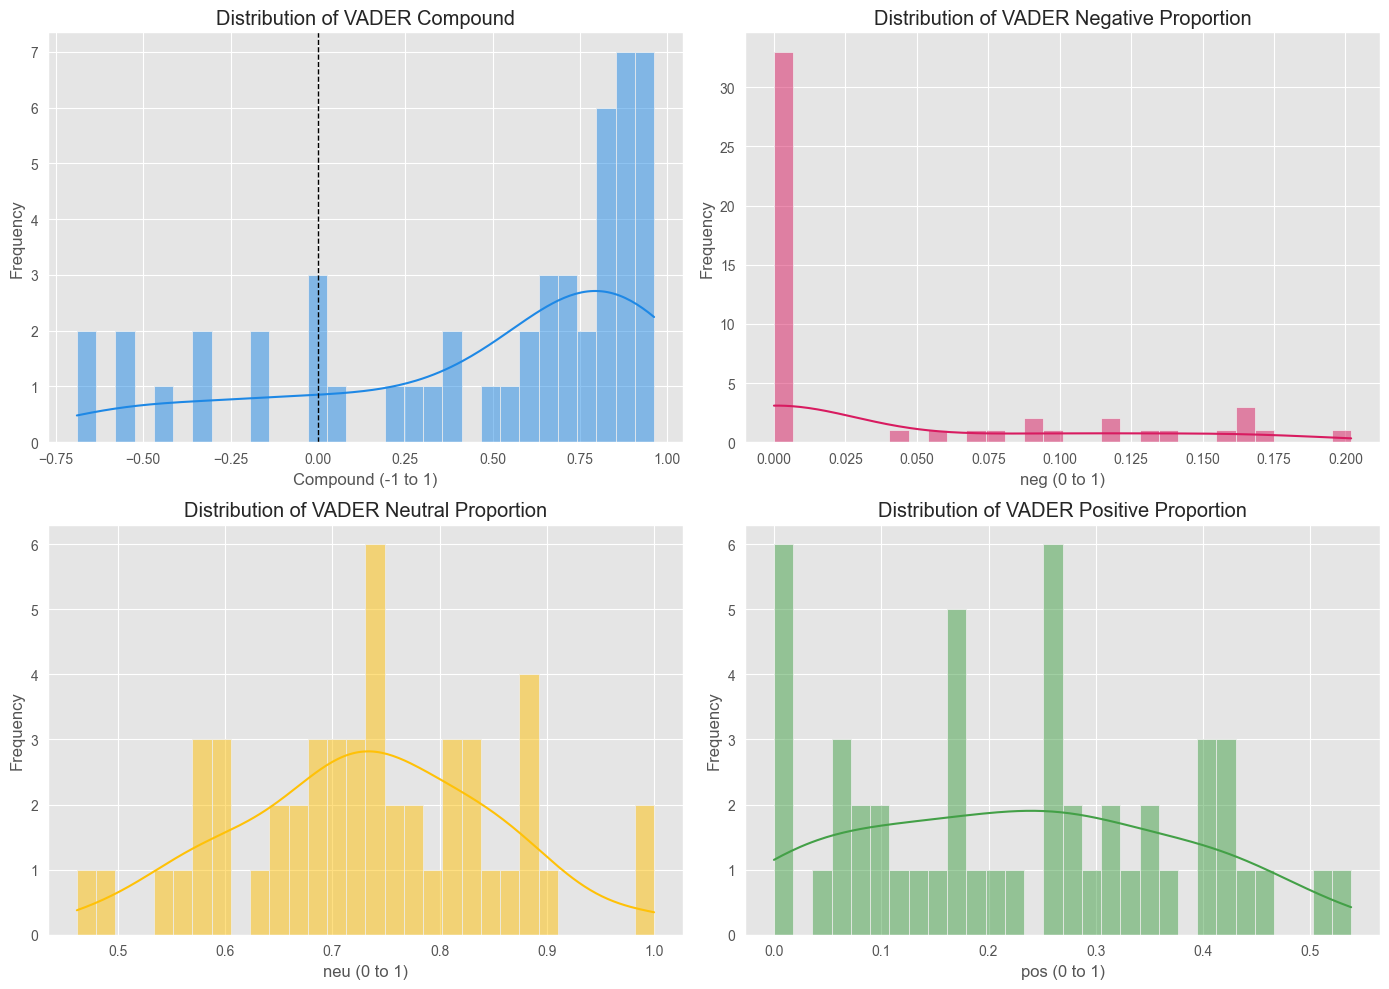

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# Compound distribution
sns.histplot(reviews_df['VADER_compound'].dropna(), bins=30, kde=True, ax=axes[0,0], color='#1E88E5')
axes[0,0].set_title('Distribution of VADER Compound')
axes[0,0].set_xlabel('Compound (-1 to 1)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(0, color='black', linestyle='--', linewidth=1)
# neg
sns.histplot(reviews_df['VADER_neg'], bins=30, kde=True, ax=axes[0,1], color='#D81B60')
axes[0,1].set_title('Distribution of VADER Negative Proportion')
axes[0,1].set_xlabel('neg (0 to 1)')
axes[0,1].set_ylabel('Frequency')
# neu
sns.histplot(reviews_df['VADER_neu'], bins=30, kde=True, ax=axes[1,0], color='#FFC107')
axes[1,0].set_title('Distribution of VADER Neutral Proportion')
axes[1,0].set_xlabel('neu (0 to 1)')
axes[1,0].set_ylabel('Frequency')
# pos
sns.histplot(reviews_df['VADER_pos'], bins=30, kde=True, ax=axes[1,1], color='#43A047')
axes[1,1].set_title('Distribution of VADER Positive Proportion')
axes[1,1].set_xlabel('pos (0 to 1)')
axes[1,1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

## Step 8 - Joint Distribution

Visualize the relationship between VADER positive and negative proportions. Each point is a review, colored by the derived sentiment label. Axis limits are set to [0, 1] for clarity.

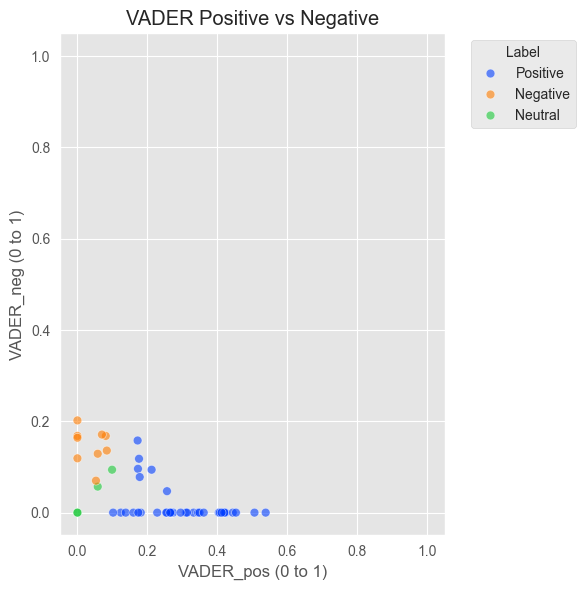

In [35]:
fig, ax = plt.subplots(1, figsize=(6, 6))
sns.scatterplot(data=reviews_df, x='VADER_pos', y='VADER_neg', hue='VADER_label', alpha=0.6, s=40)
ax.set_title('VADER Positive vs Negative')
ax.set_xlabel('VADER_pos (0 to 1)')
ax.set_ylabel('VADER_neg (0 to 1)')
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [36]:
vader = SentimentIntensityAnalyzer()

In [39]:
def vader_scores(text: str):
    s = vader.polarity_scores(str(text))
    compound = s["compound"]
    if compound >= 0.05:
        label = "Positive"
    elif compound <= -0.05:
        label = "Negative"
    else:
        label = "Neutral"
    return pd.Series([s["neg"], s["neu"], s["pos"], compound, label])

In [40]:
results = reviews_df[["VADER_neg", "VADER_neu", "VADER_pos", "VADER_compound", "VADER_label"]] = (
    reviews_df["Review Text"].apply(vader_scores)
)
print(results)

        0      1      2       3         4
0   0.000  0.690  0.310  0.9521  Positive
1   0.096  0.731  0.173  0.2144  Positive
2   0.119  0.881  0.000 -0.5665  Negative
3   0.000  0.596  0.404  0.9622  Positive
4   0.057  0.885  0.058  0.0049   Neutral
5   0.000  0.772  0.228  0.8570  Positive
6   0.070  0.877  0.053 -0.1533  Negative
7   0.000  0.668  0.332  0.9318  Positive
8   0.000  0.819  0.181  0.6369  Positive
9   0.000  0.655  0.345  0.9348  Positive
10  0.000  0.651  0.349  0.8818  Positive
11  0.168  0.751  0.081 -0.4391  Negative
12  0.000  0.593  0.407  0.9287  Positive
13  0.000  0.876  0.124  0.3716  Positive
14  0.000  0.687  0.313  0.8020  Positive
15  0.000  0.862  0.138  0.4939  Positive
16  0.000  0.581  0.419  0.7574  Positive
17  0.000  0.728  0.272  0.8622  Positive
18  0.129  0.813  0.058 -0.3163  Negative
19  0.000  0.577  0.423  0.9446  Positive
20  0.000  1.000  0.000  0.0000   Neutral
21  0.000  0.580  0.420  0.9062  Positive
22  0.168  0.832  0.000 -0.3449  N